# **Persiapan Dengan mengimport beberapa modul dan melakukan pengambilan data dari kaggle**

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'animefacedataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F379764%2F737475%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T123445Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D18ffc8b719325597a6241a93e89d0409f2a4a13ace17c039d122e50bf949a53b5b15c892e708dba723b552acef6d54b88f63f80da09fe4dd044c5a71316978812e6bb8b3f69c9417b8979e3dd9b9b4c47a0c8af9b78b6b5272b4b323557466da42f40d6fbda56fc9af21c41c4a546cc6dcf96730778950097ebc7a4248c1629c9bafb034c757bf372ba06daae362564a59b9e735516b5d3dfdc5b723d9a4553af680c8ac5905ab7b3c7209544d031bfd881628f179b6e4293177d9d2e87fd139ccca3a79cee55ac022d62755f2c1f38b7f4f3002790307cb15412027cfe57b619ad8c1959d114eb9b2860877d8f3d3c6f97f15b4bd4820e081b42833c56b80a2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 413825766 bytes downloaded
Downloaded and uncompressed: animefacedataset
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,ReLU, BatchNormalization, Softmax, Flatten, Reshape, Dense, UpSampling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

import os
import glob
from tqdm.notebook import tqdm, trange
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## Menyiapkan DataLoader


In [ ]:
image_gen = ImageDataGenerator(rescale=1./255)
target_size = (64, 64)

dataloader = image_gen.flow_from_directory(
    '/kaggle/input/animefacedataset/',
    target_size = target_size,
    batch_size = 32,
    class_mode = 'input'
)

Found 63565 images belonging to 1 classes.


## Beberap Fungsi Tambahan

In [ ]:
def upscale(data):
    return data*255

def batchplot(image_batch, batch_size=32,row=8):
    cols = int(batch_size / row)
    image_batch = image_batch

    fig, ax = plt.subplots(cols, row, figsize=(10, 10*(cols/row)))

    for i, image in enumerate(image_batch):
        ax = plt.subplot(cols, row, i+1)
        plt.imshow(image)
        ax.axis('off')

    #fig.tight_layout(pad=0)
    plt.suptitle('Sample Images')
    plt.show()



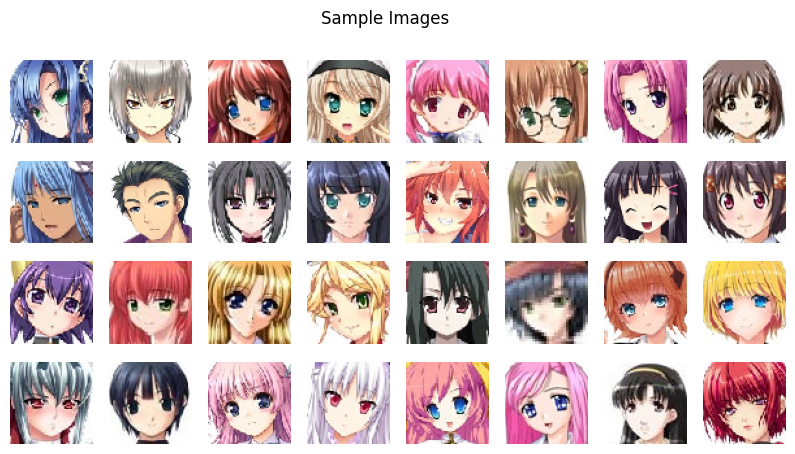

In [ ]:
image_batch, out_batch = dataloader[0]
batchplot(image_batch)

## Membangun Model Yang akan di Gunakan

## Mencari GPU yang tersedia Untuk Memproses Program

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Mengambil beberapa gambar untuk di jadikan bahan latihan mesin

In [ ]:
def build_autoencoder(input_shape):
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((4, 4), padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), padding='same'))

#     model.add(Flatten(data_format='channels_last'))
#     model.add(Dense(4*4*64, activation='relu'))
#     model.add(Dense(4*4*128, activation='relu'))
#     model.add(Reshape((4,4,128)))

    # Decoder
#     model.add(Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
#     model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((4, 4)))
    model.add(Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    return model

input_shape = (64, 64, 3)
model = build_autoencoder(input_shape)
#model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

# Melatih Mesin dengan beberapa Data yang Telah di Ambil sebelum nya

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(dataloader, epochs=10)

Epoch 1/10
1987/1987 [==============================] - 1321s 664ms/step - loss: 0.0265
Epoch 2/10
1987/1987 [==============================] - 1360s 684ms/step - loss: 0.0206
Epoch 3/10
1987/1987 [==============================] - 1320s 664ms/step - loss: 0.0192
Epoch 4/10
1987/1987 [==============================] - 1310s 659ms/step - loss: 0.0185
Epoch 5/10
1987/1987 [==============================] - 1314s 661ms/step - loss: 0.0179
Epoch 6/10
1987/1987 [==============================] - 1325s 667ms/step - loss: 0.0175
Epoch 7/10
1987/1987 [==============================] - 1369s 689ms/step - loss: 0.0172
Epoch 8/10
1987/1987 [==============================] - 1314s 661ms/step - loss: 0.0169
Epoch 9/10
1987/1987 [==============================] - 1315s 662ms/step - loss: 0.0167
Epoch 10/10
1987/1987 [==============================] - 1306s 657ms/step - loss: 0.0165


## Merekonstruksi Gambar

1/1 [==============================] - 0s 362ms/step


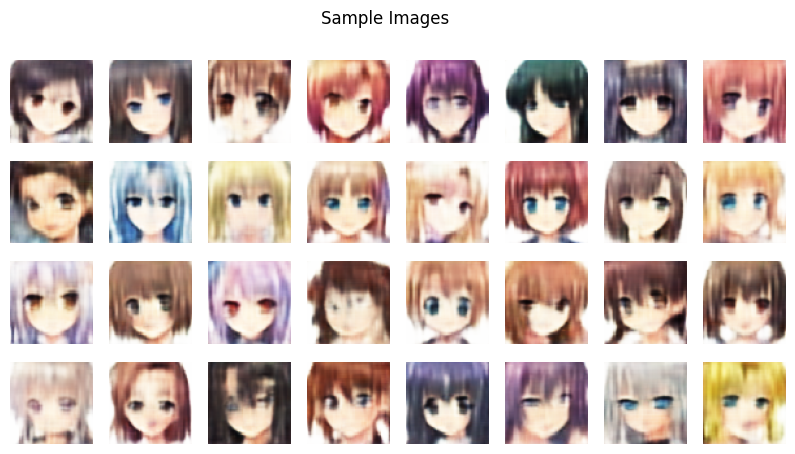

In [ ]:
images,_ = dataloader[10]
# with tf.device('/device:GPU:0'):
results = model.predict(images)
batchplot(results)

# Melakukan Percobaan Pada Latent Space Untuk Membuat Gambar Baru

In [ ]:
model.save('/kaggle/working/model1.h5')
model = tf.keras.models.load_model('/kaggle/working/model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
encoder = Model(inputs=model.input, outputs=model.layers[7].output)
decoder = Model(inputs=model.layers[8].input, outputs=model.output)

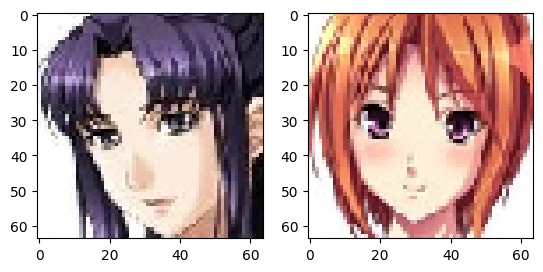

In [ ]:
img1 = dataloader[0][0][1]
img2 = dataloader[0][0][2]
img3 = dataloader[0][0][2]


plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img3)

1/1 [==============================] - 0s 37ms/step


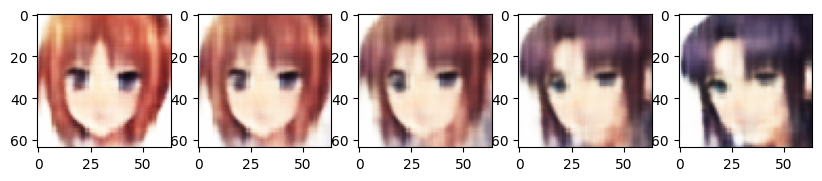

In [ ]:
en1 = encoder.predict(img1[np.newaxis, :, :, :])
en2 = encoder.predict(img2[np.newaxis, :, :, :])
en3 = encoder.predict(img3[np.newaxis, :, :, :])

plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    plt.subplot(1,5,i+1)
    en = (i/4)*en1+(1-i/4)*en3
    dec = decoder(en)
    plt.imshow(dec[0])
plt.show()

1/1 [==============================] - 0s 38ms/step


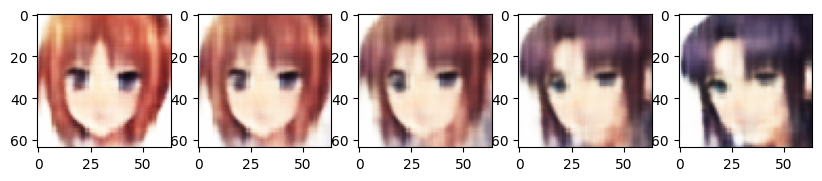

In [ ]:
en1 = encoder.predict(img1[np.newaxis, :, :, :])
en2 = encoder.predict(img2[np.newaxis, :, :, :])
en3 = encoder.predict(img3[np.newaxis, :, :, :])

plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    plt.subplot(1,5,i+1)
    en = (i/4)*en1+(1-i/4)*en3
    dec = decoder(en)
    plt.imshow(dec[0])
plt.show()

1/1 [==============================] - 0s 66ms/step


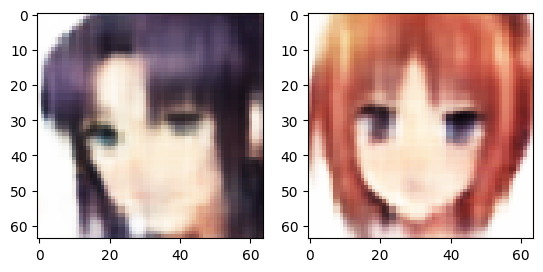

In [ ]:
pre1 = model.predict(img1[np.newaxis, :, :, :])
pre2 = model.predict(img3[np.newaxis, :, :, :])

plt.subplot(1,2,1)
plt.imshow(pre1[0])
plt.subplot(1,2,2)
plt.imshow(pre2[0])